In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("../src/gmf_assets.csv")


In [28]:
# Basic descriptive stats per asset
summary = df.groupby('Asset')[['Open', 'High', 'Low', 'Close','Volume']].describe()
print(summary)


       Open                                 High                             \
      count unique                top freq count unique                 top   
Asset                                                                         
BND    2536   2531  74.94589795853878    2  2536   2525  62.000397990855035   
SPY    2536   2536                SPY    1  2536   2534   283.9740745742894   
TSLA   2536   2430               24.0    4  2536   2429   13.41866683959961   

             Low                                Close         \
      freq count unique                top freq count unique   
Asset                                                          
BND      2  2536   2518  61.87181492417986    3  2536   2314   
SPY      2  2536   2536                SPY    1  2536   2498   
TSLA     3  2536   2448  23.46666717529297    3  2536   2483   

                               Volume                           
                      top freq  count unique          top freq  
Asset     

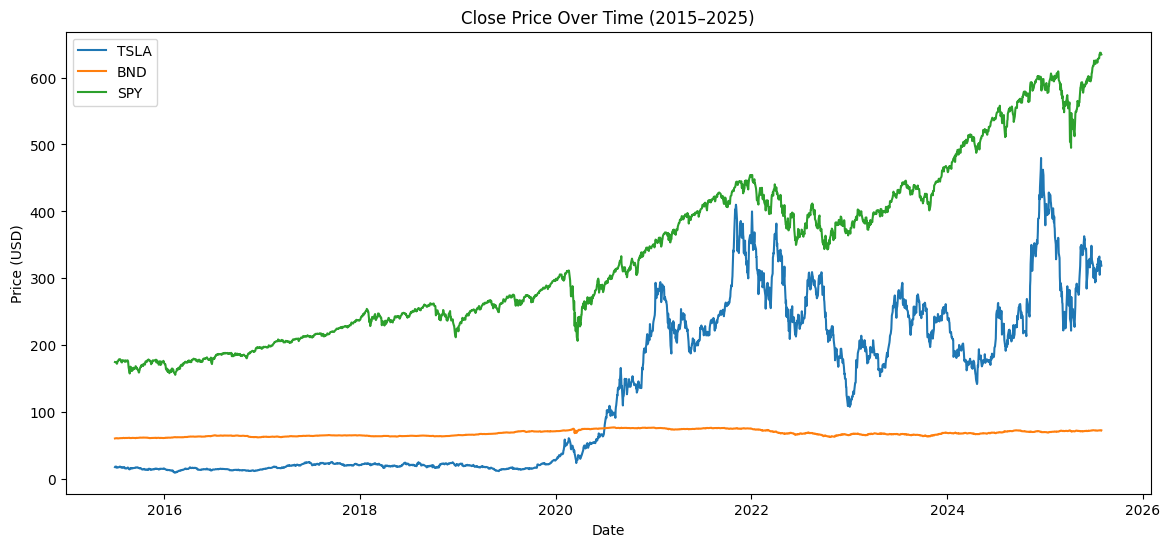

In [ ]:
# Visualize the Closing Price Over Time

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

plt.figure(figsize=(14,6))

for asset in ['TSLA', 'BND', 'SPY']:
    subset = df[df['Asset'] == asset]
    plt.plot(subset['Date'], subset['Close'], label=asset)

plt.title('Close Price Over Time (2015–2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


C:\Users\Rahwa.B\AppData\Local\Temp\ipykernel_13028\1379229828.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
C:\Users\Rahwa.B\AppData\Local\Temp\ipykernel_13028\1379229828.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
C:\Users\Rahwa.B\AppData\Local\Temp\ipykernel_13028\1379229828.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to 

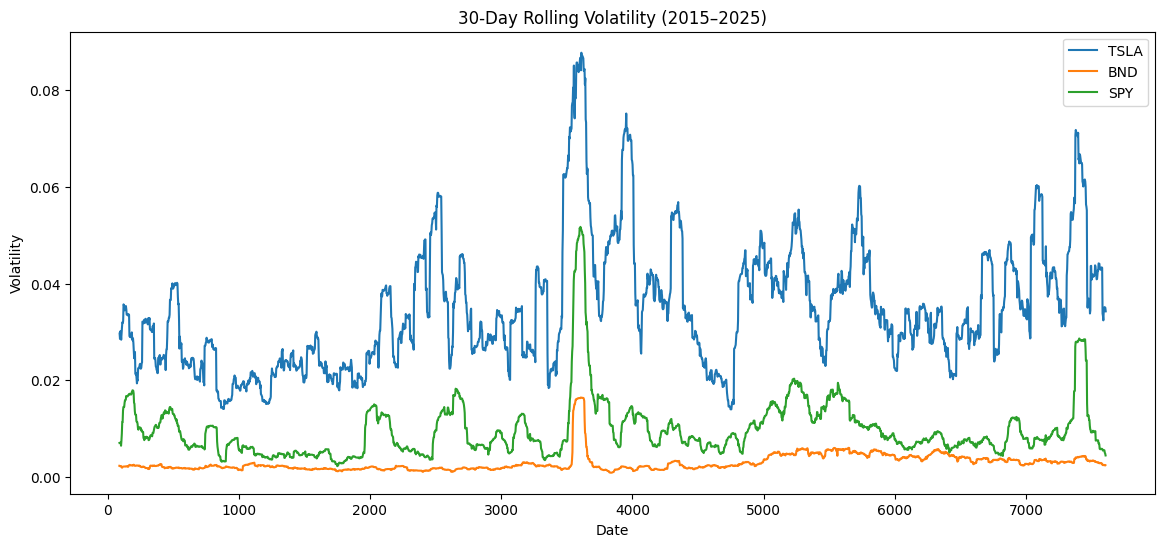

In [30]:
# Compute daily returns and rolling volatility
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def compute_volatility(df, window=30):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window).std()
    return df

tsla = df[df['Asset'] == 'TSLA']
bnd = df[df['Asset'] == 'BND']
spy = df[df['Asset'] == 'SPY']

tsla_vol = compute_volatility(tsla)
bnd_vol = compute_volatility(bnd)
spy_vol = compute_volatility(spy)


# Plot
plt.figure(figsize=(14,6))
plt.plot(tsla_vol.index, tsla_vol['Volatility'], label='TSLA')
plt.plot(bnd_vol.index, bnd_vol['Volatility'], label='BND')
plt.plot(spy_vol.index, spy_vol['Volatility'], label='SPY')
plt.title('30-Day Rolling Volatility (2015–2025)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


C:\Users\Rahwa.B\AppData\Local\Temp\ipykernel_13028\821194292.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily_Return'] = df.groupby('Asset')['Close'].pct_change() * 100


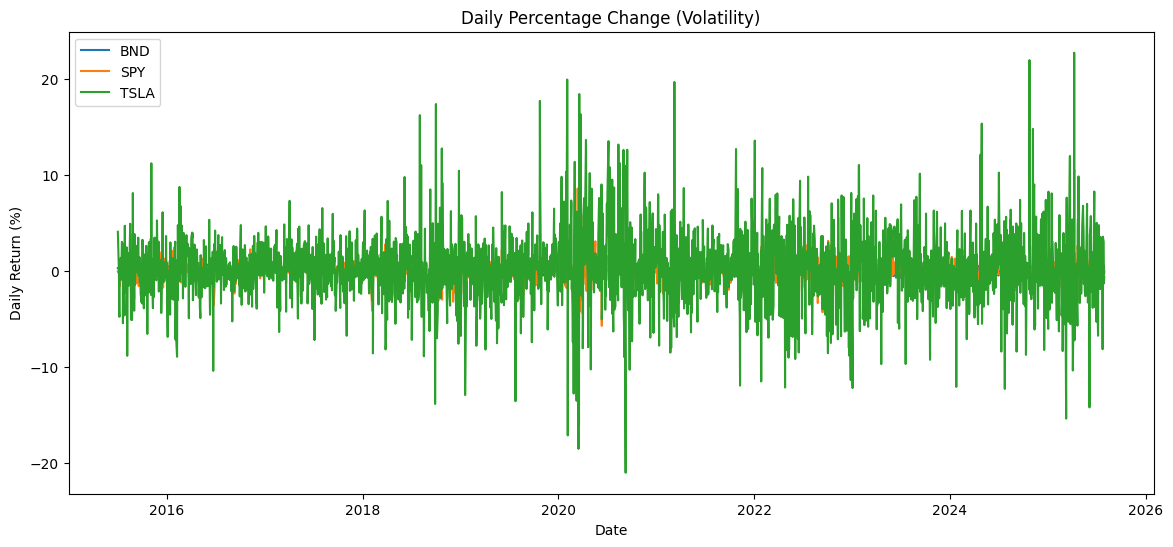

In [36]:
# Calculate daily returns (percentage change) for each asset
df['Daily_Return'] = df.groupby('Asset')['Close'].pct_change() * 100

# Plot the returns
plt.figure(figsize=(14, 6))
for asset in df['Asset'].unique():
    subset = df[df['Asset'] == asset]
    plt.plot(subset['Date'], subset['Daily_Return'], label=asset)

plt.title('Daily Percentage Change (Volatility)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()


Sample Outliers Detected:
           Date Asset  Daily_Return
3540 2020-03-10   BND     -1.344425
3543 2020-03-11   BND     -1.893908
3546 2020-03-12   BND     -5.438588
3549 2020-03-13   BND      4.220139
3552 2020-03-16   BND      1.051116


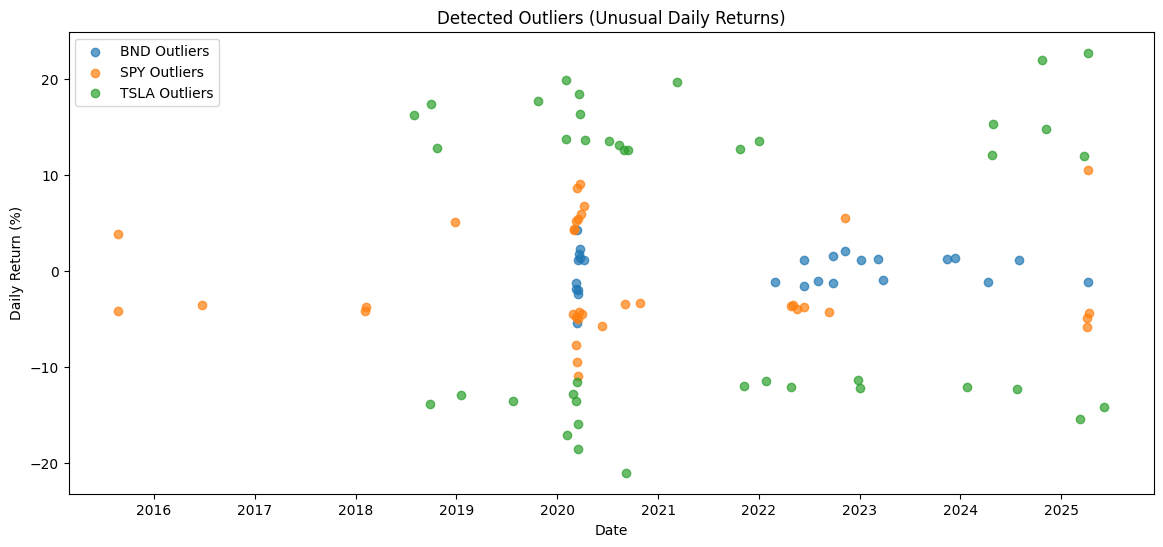

In [37]:
# Define a threshold for outliers (e.g., returns beyond ±3 standard deviations)
threshold = 3

# Group by asset and find mean/std of returns
outliers = pd.DataFrame()

for asset in df['Asset'].unique():
    subset = df[df['Asset'] == asset].copy()
    mean = subset['Daily_Return'].mean()
    std = subset['Daily_Return'].std()

    # Identify outliers
    subset['Outlier'] = ((subset['Daily_Return'] - mean).abs() > threshold * std)
    
    # Append detected outliers
    outliers = pd.concat([outliers, subset[subset['Outlier']]])

# Display some sample outliers
print("Sample Outliers Detected:")
print(outliers[['Date', 'Asset', 'Daily_Return']].head())

# Plot outliers
plt.figure(figsize=(14, 6))
for asset in df['Asset'].unique():
    asset_outliers = outliers[outliers['Asset'] == asset]
    plt.scatter(asset_outliers['Date'], asset_outliers['Daily_Return'], label=f'{asset} Outliers', alpha=0.7)

plt.title('Detected Outliers (Unusual Daily Returns)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()


Seasonality and Trends

In [38]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Function to run the Augmented Dickey-Fuller test
def run_adf_test(series, title=''):
    print(f'\nADF Test for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
    
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
        
    if result[1] <= 0.05:
        print("=> Stationary (Reject Null Hypothesis: Unit root not present)")
    else:
        print("=> Non-Stationary (Fail to Reject Null Hypothesis: Unit root present)")

# Test for stationarity on daily returns
for asset in df['Asset'].unique():
    subset = df[df['Asset'] == asset]
    run_adf_test(subset['Daily_Return'], title=f'{asset} - Daily Returns')



ADF Test for BND - Daily Returns
ADF Statistic: -9.891795885816432
p-value: 3.541899393366761e-17
# Lags Used: 23
Number of Observations: 2511
=> Stationary (Reject Null Hypothesis: Unit root not present)

ADF Test for SPY - Daily Returns
ADF Statistic: -16.267580593897797
p-value: 3.514464614430488e-29
# Lags Used: 8
Number of Observations: 2526
=> Stationary (Reject Null Hypothesis: Unit root not present)

ADF Test for TSLA - Daily Returns
ADF Statistic: -34.68899809845878
p-value: 0.0
# Lags Used: 1
Number of Observations: 2533
=> Stationary (Reject Null Hypothesis: Unit root not present)


Analyze Volatility

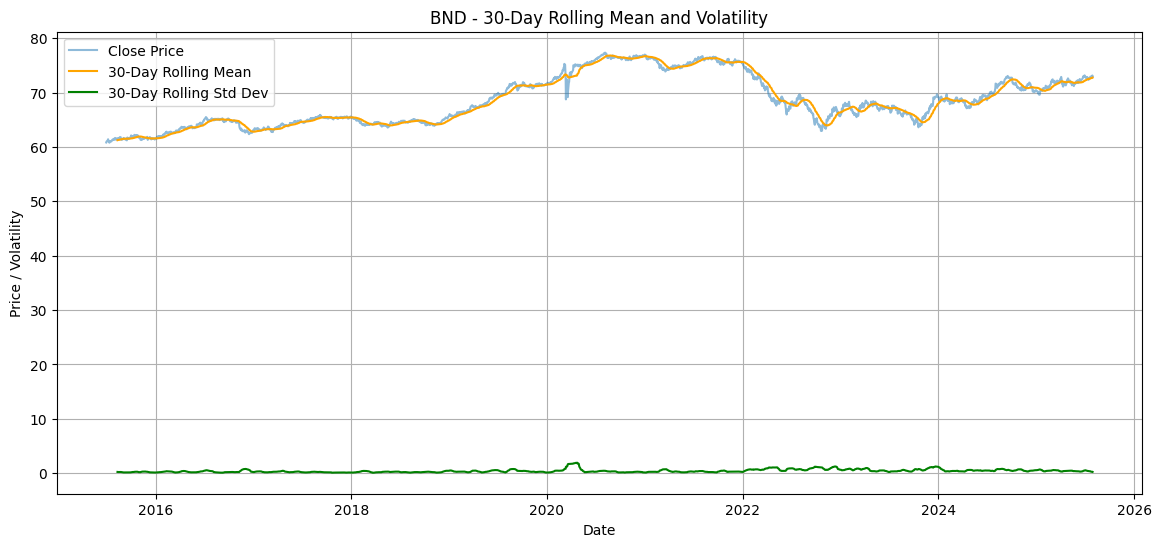

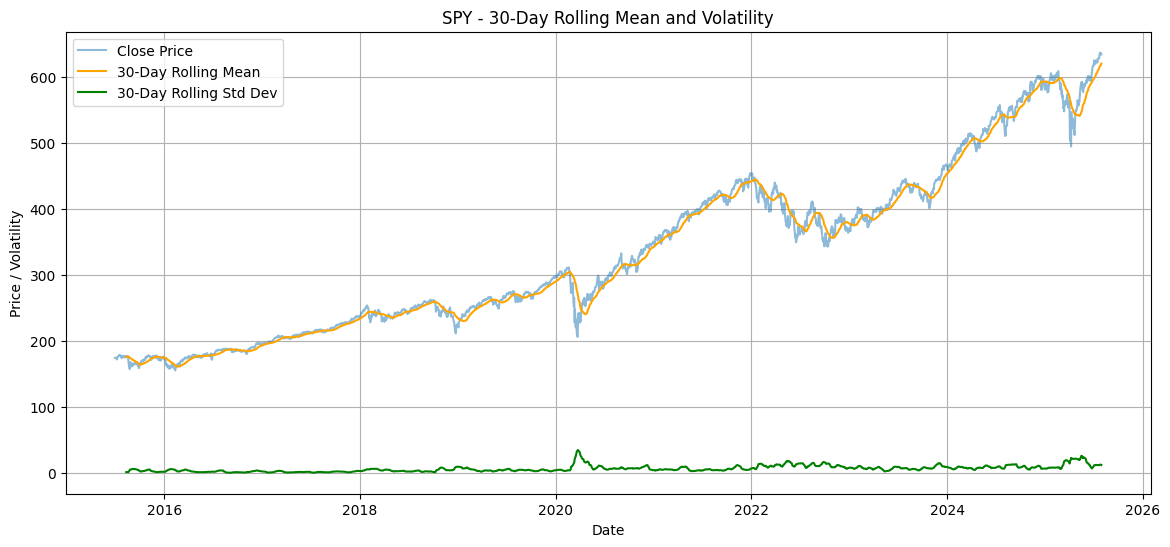

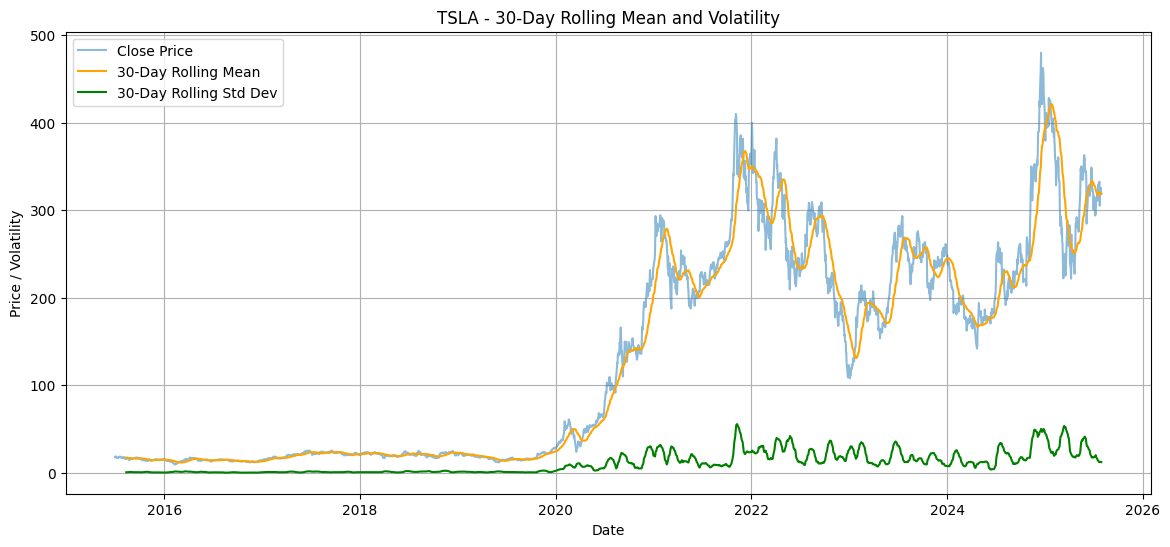

In [39]:
# Set rolling window size (30 days)
window_size = 30

# Loop through each asset
for asset in df['Asset'].unique():
    # Subset the dataframe by asset
    subset = df[df['Asset'] == asset].copy()
    
    # Calculate 30-day rolling mean and std on Close prices
    subset['Rolling_Mean'] = subset['Close'].rolling(window=window_size).mean()
    subset['Rolling_Std'] = subset['Close'].rolling(window=window_size).std()
    
    # Plot the results
    plt.figure(figsize=(14, 6))
    
    # Close price line
    plt.plot(subset['Date'], subset['Close'], label='Close Price', alpha=0.5)
    
    # Rolling mean line
    plt.plot(subset['Date'], subset['Rolling_Mean'], label=f'{window_size}-Day Rolling Mean', color='orange')
    
    # Rolling standard deviation line
    plt.plot(subset['Date'], subset['Rolling_Std'], label=f'{window_size}-Day Rolling Std Dev', color='green')
    
    # Title and labels
    plt.title(f'{asset} - {window_size}-Day Rolling Mean and Volatility')
    plt.xlabel('Date')
    plt.ylabel('Price / Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


In [40]:
# Filter TSLA data
tsla_df = df[df['Asset'] == 'TSLA'].copy()

# Calculate overall price change
overall_change = ((tsla_df['Close'].iloc[-1] - tsla_df['Close'].iloc[0]) / tsla_df['Close'].iloc[0]) * 100
print(f"Overall TSLA stock price change from {tsla_df['Date'].min().date()} to {tsla_df['Date'].max().date()}: {overall_change:.2f}%")


Overall TSLA stock price change from 2015-07-01 to 2025-07-30: nan%


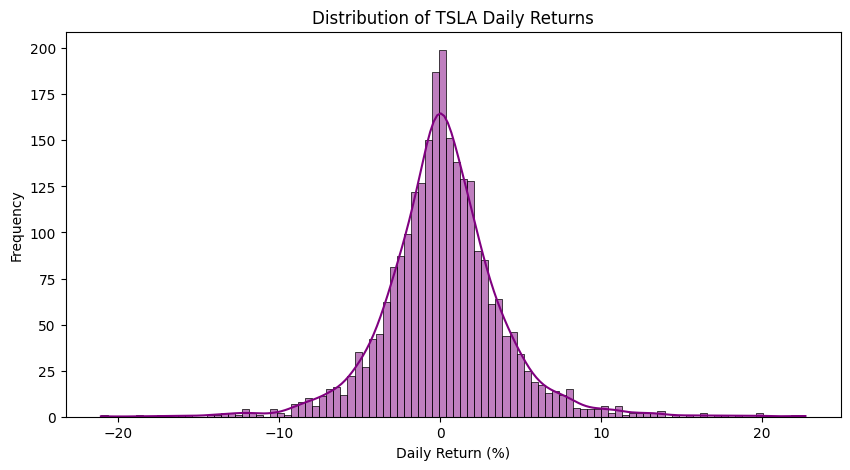

95% 1-day Value at Risk (VaR) for TSLA: -5.47%
TSLA Sharpe Ratio: 0.05


In [44]:
### Fluctuations in Daily Returns

# Visualize distribution
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(tsla_df['Daily_Return'].dropna(), bins=100, kde=True, color='purple')
plt.title('Distribution of TSLA Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()


##########################
# Value at Risk (VaR)

# Drop NA to ensure clean data
tsla_returns = tsla_df['Daily_Return'].dropna()

# Calculate 95% VaR (1-day)
var_95 = np.percentile(tsla_returns, 5)
print(f"95% 1-day Value at Risk (VaR) for TSLA: {var_95:.2f}%")


#############################################
# Sharp Ratio

# Assume daily risk-free rate
risk_free_rate = 0.02 / 252

# Calculate Sharpe Ratio
excess_return = tsla_returns / 100 - risk_free_rate  # Convert % to decimals
sharpe_ratio = excess_return.mean() / excess_return.std()
print(f"TSLA Sharpe Ratio: {sharpe_ratio:.2f}")

